In [ ]:
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib
#!pip install scikit-learn
#!pip install statsmodels
#!pip install keras
#!pip install mflow
#!pip install tensorflow
#!pip install mlflow

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Activation, Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score


#### DATA LOADING

In [2]:

dataset_path = "../data/Tetuan City power consumption.csv"
data = pd.read_csv(dataset_path, parse_dates=["DateTime"], index_col=["DateTime"])
data.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


### DATA PROCESSING

#### Detect and Impute Outliers

In [3]:

window_size = 18 # #Create sliding window of 3 hours(18 samples)
for col in ['general diffuse flows', 'Zone 3  Power Consumption', 'diffuse flows']:
    rolling_mean = data[col].rolling(window=window_size).mean()
    rolling_std = data[col].rolling(window=window_size).std()
    outliers = (data[col] -rolling_mean).abs() > 3 * rolling_std
    data.loc[outliers, col] = None  #Mask outliers as nan


In [4]:
data[['general diffuse flows', 'Zone 3  Power Consumption','diffuse flows']] = data[['general diffuse flows', 'Zone 3  Power Consumption', 'diffuse flows']].interpolate(methods = 'linear')

#### Create sliding window. Split and scale data

In [ ]:

data_hr = data.copy()
data_hr_sorted = data_hr.sort_index()

column_group = ['Zone 1 Power Consumption', 'Zone 2  Power Consumption','Zone 3  Power Consumption']

#create hourly target and select only the target columns
target = data_hr_sorted[column_group].resample('h').mean()


target[['Zone 1 Power Consumption', 'Zone 2  Power Consumption',
       'Zone 3  Power Consumption']]  = target[['Zone 1 Power Consumption', 'Zone 2  Power Consumption',
       'Zone 3  Power Consumption']].ffill()
       

X = []
y = []


for i in range(window_size, len(data_hr_sorted)-6, 6):    # step by 6 (1 hour)
    X.append(data_hr_sorted.iloc[i - window_size: i].values)
    y.append(target.iloc[i // 6].values)

X  = np.array(X) 
y = np.array(y) 


#Chronological split
split_index  = int(0.8 * len(X))
X_train = X[: split_index]  
X_test = X[split_index:]
y_train = y[: split_index]
y_test = y[split_index:]


#Scale X
x_scaler = MinMaxScaler()  #expect 2D : (samples, features)
X_train_scaled = x_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape) 
X_test_scaled =  x_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

#Scale y
y_scaler =   MinMaxScaler()
y_train_scaled =  y_scaler.fit_transform(y_train)
y_test_scaled =  y_scaler.transform(y_test)



# Reshape y
y_train_scaled = y_train_scaled.reshape(y_train_scaled.shape[0], 1, y_train_scaled.shape[1]) 
y_test_scaled = y_test_scaled.reshape(y_test_scaled.shape[0], 1, y_test_scaled.shape[1])



#batch_size = 32

n_timesteps       = X_train_scaled.shape[1] 
n_features        = X_train_scaled.shape[2] 
n_output_features = y_train_scaled.shape[2] 




### HYPER-PARAMETER TUNING

#### Based on Random search of two model architectures

In [11]:

def build_lstm_model(X_train_scaled, y_train_scaled, lstm_units, dropout_rate,learning_rate, num_epochs, batch_size):
    model = Sequential()
    model.add(LSTM(lstm_units,  input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True, activation='relu'))
    model.add(LSTM(lstm_units//2, return_sequences=False, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train_scaled.shape[1] * y_train_scaled.shape[2], activation='linear'))  # Output layer with linear activation
    model.add(tf.keras.layers.Reshape((y_train_scaled.shape[1], y_train_scaled.shape[2])))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    history = model.fit(X_train_scaled, y_train_scaled, epochs=num_epochs, batch_size=batch_size,validation_split=0.2, verbose=0)
    
    return model, history

def lstm_gru_model(X_train_scaled, y_train_scaled, lstm_units,dropout_rate,learning_rate, num_epochs, batch_size ):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate,))
    model.add(BatchNormalization())
    model.add(GRU(lstm_units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train_scaled.shape[1] * y_train_scaled.shape[2], activation='linear')) 
    model.add(Reshape((y_train_scaled.shape[1], y_train_scaled.shape[2])))  # Reshape to (24, 3)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    history = model.fit(X_train_scaled, y_train_scaled, epochs=num_epochs, batch_size=batch_size,validation_split=0.2, verbose=0)
    return model, history
    
   

def hyper_param_tuning():

    # Define hyperparameter search space
    param_space = {
        'lstm_units': [32, 64, 96, 128],
        'dropout_rate': [0.1, 0.2, 0.3],
        'learning_rate': [0.01, 0.001, 0.0001],
        'batch_size': [16, 32, 64],
        'epochs': [30, 50, 70] 
    }

    # Number of random search iterations
    n_iterations = 10

    best_loss = float('inf')
    best_params = None
    best_model = None
    history_list = [] # To store training history

    # Ensure n_features and n_output_features are defined based on the scaled data
    n_timesteps = X_train_scaled.shape[1]
    n_features = X_train_scaled.shape[2]
    n_output_features = y_train_scaled.shape[2]


    # Perform Random Search
    for i in range(n_iterations):
        print(f"Starting Random Search Iteration {i+1}/{n_iterations}")

        # Sample hyperparameters
        params = {
            'lstm_units': random.choice(param_space['lstm_units']),
            'dropout_rate': random.choice(param_space['dropout_rate']),
            'learning_rate': random.choice(param_space['learning_rate']),
            'batch_size': random.choice(param_space['batch_size']),
            'epochs': random.choice(param_space['epochs'])
        }
        print(f"  Trying parameters: {params}")

        ''' # Build and compile model
        model = build_lstm_model(n_timesteps, n_features, n_output_features,
                                lstm_units=params['lstm_units'],
                                dropout_rate=params['dropout_rate'],
                                learning_rate=params['learning_rate']) '''
        
        # Build and compile model
        model_1, history_1 = build_lstm_model(X_train_scaled, y_train_scaled, 
                                   lstm_units=params['lstm_units'], 
                                   dropout_rate=params['dropout_rate'],
                                   learning_rate=params['learning_rate'],
                                   num_epochs=params['epochs'],
                                   batch_size=params['batch_size'])
        
        model_2, history_2 = lstm_gru_model(X_train_scaled, y_train_scaled, 
                                   lstm_units=params['lstm_units'], 
                                   dropout_rate=params['dropout_rate'],
                                   learning_rate=params['learning_rate'],
                                   num_epochs=params['epochs'],
                                   batch_size=params['batch_size'])
        
        models_history_list = [(model_1, history_1),  (model_2, history_2)]
        
        best_model = None
        best_score = float('inf')

        for model_history in models_history_list:
            model, history = model_history
        

            # Train model
            # Use validation_split for evaluation during training
            history = model.fit(
                X_train_scaled, y_train_scaled,
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                validation_split=0.2,
                verbose=0 
            )
            history_list.append(history)

            # Evaluate on the validation set
            val_loss = history.history['val_loss'][-1]
            print(f"  Validation Loss: {val_loss:.6f}")

            # Check if current model is the best
            if val_loss < best_loss:
                best_loss = val_loss
                best_params = params
                print("  New best model found!")
                
                
            val_losses = history.history.get('val_loss')
            if val_losses is None:
                raise ValueError(f"Metric: '{val_losses}' not available")
            
            final_score = val_losses[-1]
                
            if final_score < best_score:
                best_score = final_score
                best_model =  model
                
            #initial best model and best score

        print("\nRandom Search Finished.")
        print(f"Best Validation Loss: {best_loss:.6f}")
        print(f"Best Hyperparameters: {best_params}")
    return best_model
        
hyper_param_tuning()


Starting Random Search Iteration 1/10
  Trying parameters: {'lstm_units': 96, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 70}


c:\Users\Lenovo\Documents\Projects_sds\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  Validation Loss: 0.003470
  New best model found!
  Validation Loss: 0.005219

Random Search Finished.
Best Validation Loss: 0.003470
Best Hyperparameters: {'lstm_units': 96, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 70}
Starting Random Search Iteration 2/10
  Trying parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
  Validation Loss: 0.003394
  New best model found!
  Validation Loss: 0.007110

Random Search Finished.
Best Validation Loss: 0.003394
Best Hyperparameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 30}
Starting Random Search Iteration 3/10
  Trying parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 30}
  Validation Loss: 0.002965
  New best model found!
  Validation Loss: 0.005781

Random Search Finished.
Best Validation Loss: 0.002965
Best Hyperparameters: {'lstm_units': 64, 'dropou

<Sequential name=sequential_18, built=True>

### TRAINING BEST MODEL

#### Train hyper-parameter-tuned model

c:\Users\Lenovo\Documents\Projects_sds\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7820 - loss: 0.0135 - val_accuracy: 0.9341 - val_loss: 0.0067
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8266 - loss: 0.0054 - val_accuracy: 0.9091 - val_loss: 0.0034
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8513 - loss: 0.0044 - val_accuracy: 0.9384 - val_loss: 0.0043
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8654 - loss: 0.0036 - val_accuracy: 0.9384 - val_loss: 0.0022
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8810 - loss: 0.0031 - val_accuracy: 0.9406 - val_loss: 0.0023
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8760 - loss: 0.0028 - val_accuracy: 0.9420 - val_loss: 0.0027
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8858 - loss: 0.0025 - val_accuracy: 0.9406 - val_loss: 0.0019
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8878 - loss: 0.0023 - val_acc

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3684\447887206.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


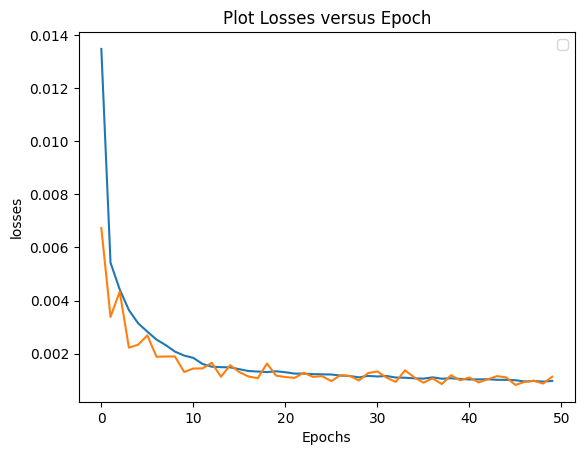

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
  New best model found!

Zone 1 - TOTAL: RMSE: 2142.59, MAE: 1899.88, R²: 0.88
Zone 1 - Mean Daily RMSE: 2095.79, MAE: 1900.88, R²: 0.84


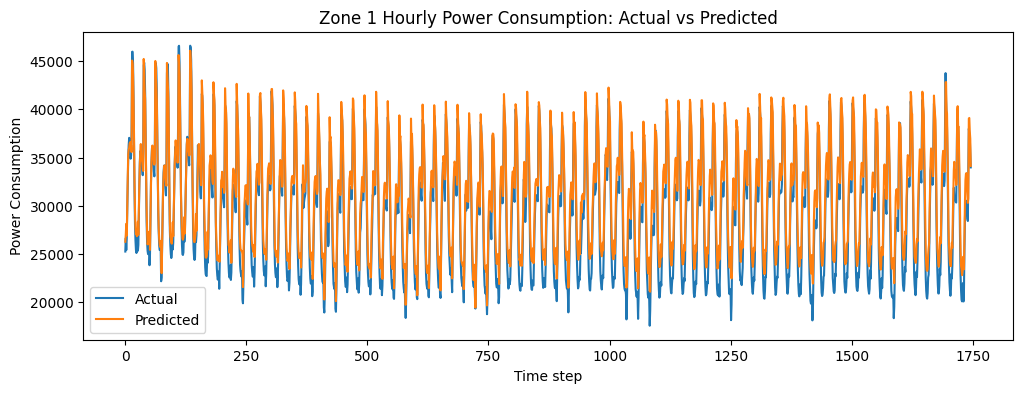


Zone 2 - TOTAL: RMSE: 1726.74, MAE: 1359.65, R²: 0.91
Zone 2 - Mean Daily RMSE: 1663.52, MAE: 1359.63, R²: 0.89


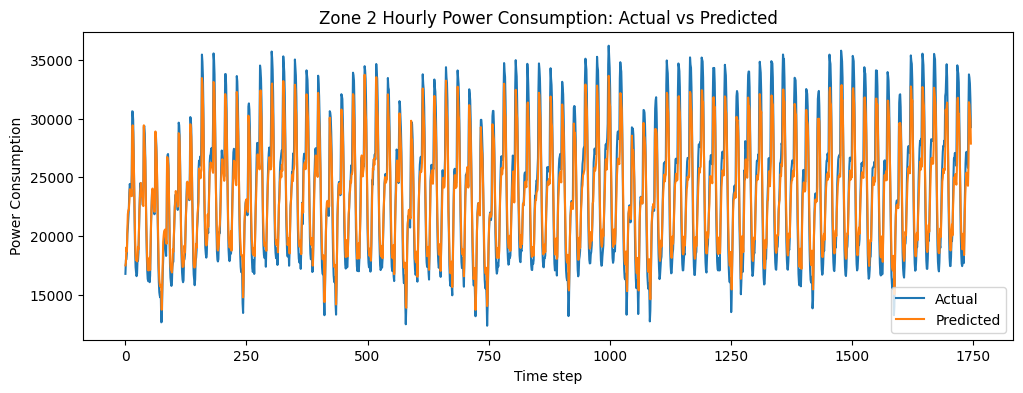


Zone 3 - TOTAL: RMSE: 2853.47, MAE: 2668.11, R²: 0.26
Zone 3 - Mean Daily RMSE: 2796.26, MAE: 2668.31, R²: -0.37


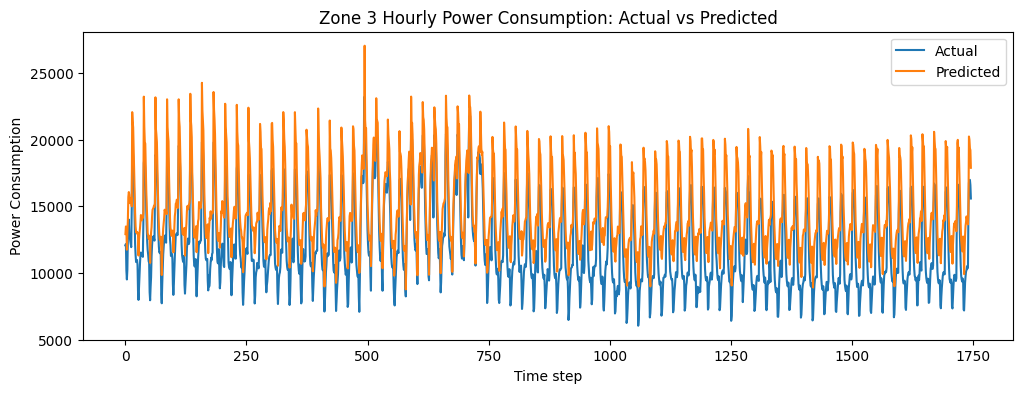

In [ ]:
best_model = Sequential()
best_model.add(LSTM(64,  input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True, activation='relu'))
best_model.add(LSTM(32, return_sequences=False, activation='relu'))
best_model.add(Dropout(0.1))
best_model.add(Dense(y_train_scaled.shape[1] * y_train_scaled.shape[2], activation='linear'))  # Output layer with linear activation
best_model.add(tf.keras.layers.Reshape((y_train_scaled.shape[1], y_train_scaled.shape[2])))
optimizer = Adam(learning_rate=0.001)
best_model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
history = best_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=16,validation_split=0.2)


plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('losses')
plt.title('Plot Losses versus Epoch')
plt.legend()
plt.show()

# Predict 

y_pred = best_model.predict(X_test_scaled)

# Inverse transform predictions. Pad zeros for the non-target features:
pad_cols = n_features - n_output_features
zeros_for_pred = np.zeros((y_pred.reshape(-1, n_output_features).shape[0], pad_cols))
pred_full  = np.concatenate([zeros_for_pred, y_pred.reshape(-1, n_output_features)], axis=1) 
inv_pred = x_scaler.inverse_transform(pred_full)[:, -n_output_features:]
inv_pred = inv_pred.reshape(y_pred.shape)  
zeros_for_true = np.zeros((y_test_scaled.reshape(-1, n_output_features).shape[0], pad_cols))
true_full = np.concatenate( [zeros_for_true, y_test_scaled.reshape(-1, n_output_features)], axis=1)
inv_true = x_scaler.inverse_transform(true_full)[:, -n_output_features:]
inv_true = inv_true.reshape(y_test_scaled.shape)


# Print Total and Daily Scores for Each Zone
best_loss = float('inf')

    
# Evaluate on the validation set
val_loss = history.history['val_loss'][-1]
    

# Check if current model is the best
if val_loss < best_loss:
    best_loss = val_loss
    #best_params = params
    best_model = best_model
    print("  New best model found!")



zones = ['Zone 1', 'Zone 2', 'Zone 3']
timesteps_per_day = 18  # adjust if different

for i, zone in enumerate(zones):

    y_true = inv_true[:, 0, i]  # flatten to 1D
    y_pred = inv_pred[:, 0, i]  # flatten to 1D

    # Total metrics
    rmse_total = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_total = mean_absolute_error(y_true, y_pred)
    r2_total = r2_score(y_true, y_pred)
    print(f'\n{zone} - TOTAL: RMSE: {rmse_total:.2f}, MAE: {mae_total:.2f}, R²: {r2_total:.2f}')

    # Daily metrics
    num_days = len(y_true) // timesteps_per_day
   
    #Mean of Daily Scores
    daily_rmse = []
    daily_mae = []
    daily_r2 = []
    for day in range(num_days):
        start = day * timesteps_per_day
        end = start + timesteps_per_day
        daily_rmse.append(np.sqrt(mean_squared_error(y_true[start:end], y_pred[start:end])))
        daily_mae.append(mean_absolute_error(y_true[start:end], y_pred[start:end]))
        daily_r2.append(r2_score(y_true[start:end], y_pred[start:end]))
    print(f'{zone} - Mean Daily RMSE: {np.mean(daily_rmse):.2f}, MAE: {np.mean(daily_mae):.2f}, R²: {np.mean(daily_r2):.2f}')


    # Plot actual vs predicted
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'{zone} Hourly Power Consumption: Actual vs Predicted')
    plt.xlabel('Time step')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.show()

### HOURLYFORECAST

#### Single-step - Forecast next hour energy consumption for the three zones based on previous three hours

In [ ]:
# Select last 3 hours from test set
last_input = X_test_scaled[-1, -3:, :]  
last_input = last_input.reshape(1, 3, n_features) 

# Predict next hour
y_pred_next = best_model.predict(last_input)  # shape: (1, 1, n_output_features)

# Inverse transform
pad_cols = n_features - n_output_features
zeros_for_pred = np.zeros((1, pad_cols))
pred_full = np.concatenate([zeros_for_pred, y_pred_next.reshape(1, n_output_features)], axis=1)
inv_next = x_scaler.inverse_transform(pred_full)[:, -n_output_features:]

# Print forecast
for i, zone in enumerate(zones):
    print(f'Forecast for next hour - {zone}: {inv_next[0, i]:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Forecast for next hour - Zone 1: 36472.65
Forecast for next hour - Zone 2: 27799.61
Forecast for next hour - Zone 3: 21250.98


#### Multi-step: Forcast the next six hours energy consumptions in the three zones based on last three hours energy value

In [15]:
def multi_step_forecast3(model, last_sequence, x_scaler, n_steps, n_features, n_output_features):
    predictions = []
    current_input = last_sequence.copy()

    pad_cols = n_features - n_output_features

    for _ in range(n_steps):
        # Predict next step (output is scaled)
        y_pred_scaled = best_model.predict(current_input)  

        # Inverse transform for storing and displaying
        zeros_for_pred_inv = np.zeros((1, pad_cols))
        pred_full_inv = np.concatenate([zeros_for_pred_inv, y_pred_scaled.reshape(1, n_output_features)], axis=1)
        inv_pred = x_scaler.inverse_transform(pred_full_inv)[:, -n_output_features:]
        predictions.append(inv_pred.flatten())

        # Prepare the scaled prediction to be appended to the input sequence
        zeros_for_pred_scaled = np.zeros((1, 1, pad_cols))
        padded_pred_scaled = np.concatenate([zeros_for_pred_scaled, y_pred_scaled], axis=2) 

        # Update input sequence by removing oldest timestep and appending new scaled prediction
        current_input = np.concatenate([current_input[:, 1:, :], padded_pred_scaled], axis=1)

    return np.array(predictions)  

In [16]:
def walk_forward_forecast(model, test_groups_scaled, scaler, input_days=2, output_days=1, target_columns=['Zone 1 Power Consumption', 'Zone 2  Power Consumption','Zone 3  Power Consumption']):
    """
    Walk-forward validation: for each test week, use the previous input_days as input, predict the next output_days,
    update history, store predictions, and print total and daily scores for each zone.
    """
    import numpy as np
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    import matplotlib.pyplot as plt

 
    history = []
    initial_history_needed = input_days + output_days - 1 

    current_history_length = 0
    for group in test_groups_scaled:
        history.append(group.copy())
        current_history_length += len(group)
        if current_history_length >= initial_history_needed:
            break

    predictions = []
    actuals = []
    n_features = history[0].shape[1]
    n_targets = len(target_columns)
    # Target indices are relative to the full feature set
    target_indices = [history[0].columns.get_loc(col) for col in target_columns]

    # Iterate through the test groups starting from where the initial history ends
    start_index = len(history) -1 if len(history) > 0 else 0 
    if start_index >= len(test_groups_scaled):
        print("Not enough data in test set for initial history.")
        return None, None


    for i in range(start_index, len(test_groups_scaled)):
        # Use the current history to create the input window
        current_history_df = pd.concat(history)
        # Ensure there's enough data in history for the input window
        if len(current_history_df) < input_days:
             print(f"History not long enough for input window in group {i}. Skipping.")
             # Update history with the current group even if skipping prediction
             history.append(test_groups_scaled[i])
             continue

        # Create the input window from the end of the history
        X_input = current_history_df.iloc[-input_days:].values.reshape(1, input_days, n_features)

        # Predict the next output_days
        y_pred_scaled = model.predict(X_input)  # shape: (1, output_days, n_targets)

        # Inverse transform prediction
        y_pred_flat = y_pred_scaled.reshape(-1, n_targets)
        y_pred_padded = np.concatenate([np.zeros((y_pred_flat.shape[0], n_features - n_targets)), y_pred_flat], axis=1)
        y_pred_inv = scaler.inverse_transform(y_pred_padded)[:, -n_targets:]
        predictions.append(y_pred_inv)

        # Get actual next output_days from the current test group
        actual_week_scaled = test_groups_scaled[i].iloc[:output_days][target_columns].values 

        actual_padded = np.concatenate([np.zeros((actual_week_scaled.shape[0], n_features - n_targets)), actual_week_scaled], axis=1)
        actual_inv = scaler.inverse_transform(actual_padded)[:, -n_targets:]
        actuals.append(actual_inv)

        # Update history with the actual data from the current test group
        history.append(test_groups_scaled[i])


    # Stack predictions and actuals
    if not predictions or not actuals:
        print("No predictions were made. Check data splitting and window sizes.")
        return None, None

    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)


    # Print total and daily scores for each zone
    timesteps_per_score = output_days

    for idx, zone in enumerate(['Zone 1', 'Zone 2', 'Zone 3']):
        # Ensure there are enough actual data points for evaluation
        if len(actuals) == 0:
             print(f"No actual data available for {zone} evaluation.")
             continue

        rmse = np.sqrt(mean_squared_error(actuals[:, idx], predictions[:, idx]))
        mae = mean_absolute_error(actuals[:, idx], predictions[:, idx])
        r2 = r2_score(actuals[:, idx], predictions[:, idx])
        print(f'{zone} - Total RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}')

        # Daily scores (or scores per output_days)
        print(f'{zone} - Scores per {output_days} steps:')
        num_scores = len(actuals) // timesteps_per_score
        daily_rmse = []
        daily_mae = []
        daily_r2 = []
     
        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(actuals[:, idx], label='Actual')
        plt.plot(predictions[:, idx], label='Predicted')
        plt.title(f'{zone} Power Consumption: Actual vs Predicted (Walk-forward)')
        plt.xlabel(f'Time step (each step represents {output_days} original time steps)')
        plt.ylabel('Power Consumption')
        plt.legend()
        plt.show()

    return predictions, actuals

In [17]:

lookback = 3
n_steps = 6
last_sequence= X_test_scaled[-1, -3:, :]
last_sequence = last_sequence.reshape(1, lookback, n_features)


future_predictions = multi_step_forecast3(best_model, last_sequence, x_scaler, n_steps, n_features, n_output_features)

# Print results
zones = ['Zone 1', 'Zone 2', 'Zone 3']
for step, pred in enumerate(future_predictions):
    print(f"\nForecast Hour {step+1}:")
    for i, zone in enumerate(zones):
        print(f"{zone}: {pred[i]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Forecast Hour 1:
Zone 1: 36472.65
Zone 2: 27799.61
Zone 3: 21250.98

Forecast Hour 2:
Zone 1: 39103.53
Zone 2: 28906.66
Zone 3: 24233.16

Forecast Hour 3:
Zone 1: 40944.76
Zone 2: 29259.54
Zone 3: 25911.43

Forecast Hour 4:
Zone 1: 40308.94
Zone 2: 28509.37
Zone 3: 26654.07

Forecast Hour 5:
Zone 1: 39264.12
Zone 2: 27427.34
Zone 3: 26078.23

Forecast Hour 6:
Zone 1: 38350.78
Zone 2: 26607.43
Zone 3: 25670.88


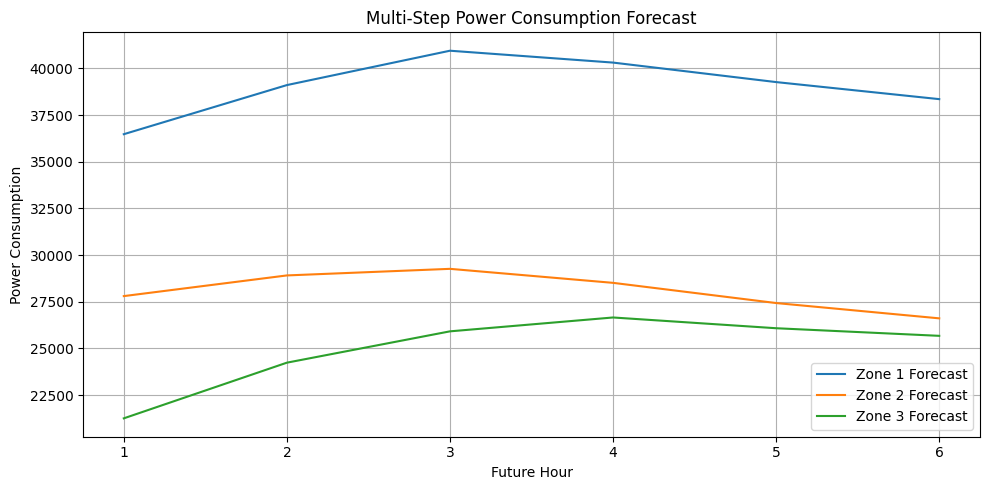

In [18]:
#Optional: Plot Multi-Step Forecas
plt.figure(figsize=(10, 5))
for i, zone in enumerate(zones):
    plt.plot(range(1, n_steps + 1), future_predictions[:, i], label=f'{zone} Forecast')
plt.title('Multi-Step Power Consumption Forecast')
plt.xlabel('Future Hour')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()